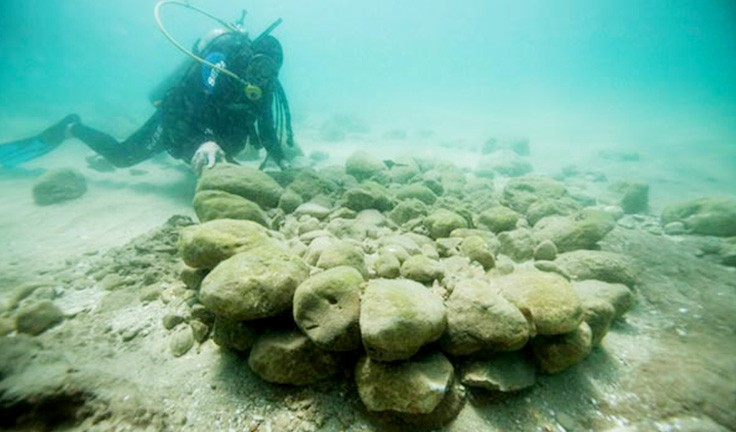

In [1]:
from PIL import Image
import requests

url = '/kaggle/input/underwater-images/img.jpg'
image = Image.open(url)
image

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

processor = AutoImageProcessor.from_pretrained("nielsr/depth-anything-small")
model = AutoModelForDepthEstimation.from_pretrained("nielsr/depth-anything-small")

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

In [3]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 518, 882])


In [4]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  predicted_depth = outputs.predicted_depth

In [5]:
import cv2
import numpy as np

h, w = image.size[::-1]

depth = torch.nn.functional.interpolate(predicted_depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
raw_depth.save("predicted_depth.png")

depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.cpu().numpy().astype(np.uint8)
colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

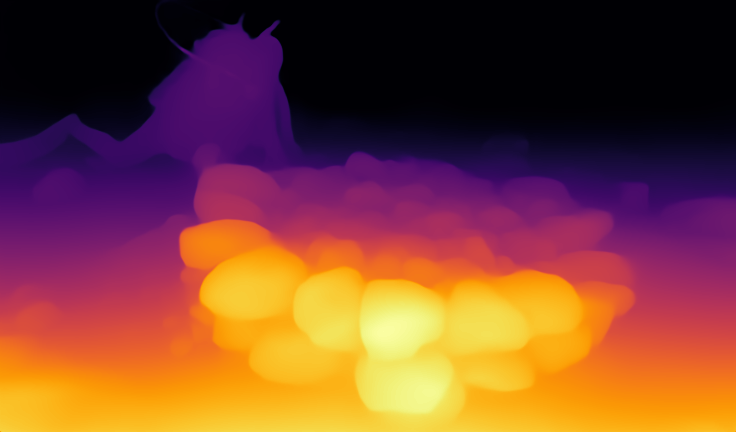

In [6]:
Image.fromarray(colored_depth)

In [7]:
from PIL import Image
import torch
import cv2
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

def process_underwater_image(image_path):
    """
    Process an underwater image using a depth estimation model.

    Args:
        image_path (str): Path to the input image.

    Returns:
        PIL.Image.Image: The depth-estimated image with a colormap applied.
    """
    # Load the image
    image = Image.open(image_path)

    # Load the model and processor
    processor = AutoImageProcessor.from_pretrained("nielsr/depth-anything-small")
    model = AutoModelForDepthEstimation.from_pretrained("nielsr/depth-anything-small").cuda()

    # Preprocess the image
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.cuda()

    # Perform inference
    with torch.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth

    # Resize the predicted depth to match the input image dimensions
    h, w = image.size[::-1]
    depth = torch.nn.functional.interpolate(
        predicted_depth[None], (h, w), mode='bilinear', align_corners=False
    )[0, 0]

    # Normalize and save the raw depth image
    raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
    raw_depth.save("predicted_depth.png")

    # Normalize and apply a colormap to the depth image
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.cpu().numpy().astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

    # Convert the result back to a PIL image
    result_image = Image.fromarray(colored_depth)

    return result_image




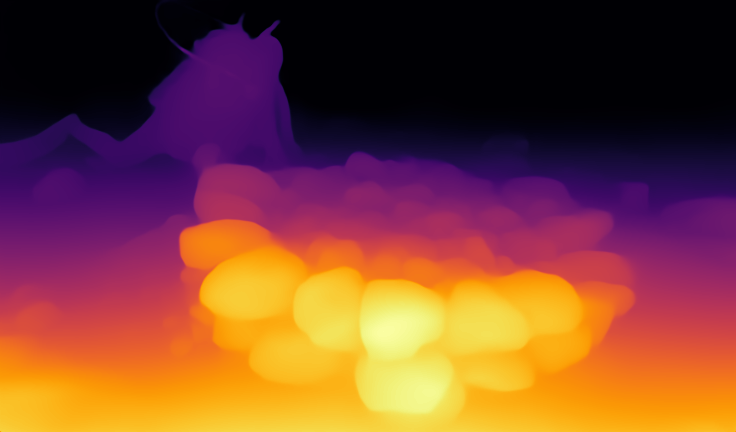

In [8]:
processed_image = process_underwater_image('/kaggle/input/underwater-images/img.jpg')
processed_image

In [10]:
from PIL import Image
import torch
import cv2
import numpy as np
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import tempfile
import os
from tqdm import tqdm

def process_video_depth(input_video_path, output_video_path):
    """
    Process a video using depth estimation model, applying it to each frame.
    Shows progress with tqdm progress bar.
    
    Args:
        input_video_path (str): Path to the input video file
        output_video_path (str): Path where the processed video will be saved
    """
    # Load the model and processor once
    print("Loading depth estimation model...")
    processor = AutoImageProcessor.from_pretrained("nielsr/depth-anything-small")
    model = AutoModelForDepthEstimation.from_pretrained("nielsr/depth-anything-small").cuda()
    print("Model loaded successfully!")
    
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise ValueError("Error opening video file")
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"\nVideo Properties:")
    print(f"Resolution: {frame_width}x{frame_height}")
    print(f"FPS: {fps}")
    print(f"Total Frames: {total_frames}")
    print(f"Estimated Duration: {total_frames/fps:.2f} seconds\n")
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    try:
        # Initialize progress bar
        with tqdm(total=total_frames, desc="Processing Frames", 
                 bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}') as pbar:
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Convert to PIL Image
                pil_image = Image.fromarray(frame_rgb)
                
                # Process frame
                pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values.cuda()
                
                # Perform inference
                with torch.no_grad():
                    outputs = model(pixel_values)
                    predicted_depth = outputs.predicted_depth
                
                # Resize the predicted depth
                depth = torch.nn.functional.interpolate(
                    predicted_depth[None], 
                    (frame_height, frame_width), 
                    mode='bilinear', 
                    align_corners=False
                )[0, 0]
                
                # Normalize depth values
                depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
                depth = depth.cpu().numpy().astype(np.uint8)
                
                # Apply colormap
                colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
                
                # Write the frame
                out.write(colored_depth)
                
                # Update progress bar
                pbar.update(1)
                
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        
    finally:
        # Release resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        torch.cuda.empty_cache()
        print("\nResources released successfully!")

def process_video_with_progress(input_video_path, output_video_path, save_interim=False):
    """
    Process a video with progress tracking and optional interim frame saving.
    
    Args:
        input_video_path (str): Path to the input video file
        output_video_path (str): Path where the processed video will be saved
        save_interim (bool): If True, saves interim frames as images
    """
    try:
        print(f"\nStarting video processing...")
        print(f"Input video: {input_video_path}")
        print(f"Output video: {output_video_path}")
        
        # Create interim directory if needed
        if save_interim:
            interim_dir = "interim_frames"
            os.makedirs(interim_dir, exist_ok=True)
            print(f"Created interim directory: {interim_dir}")
            
        # Process the video
        process_video_depth(input_video_path, output_video_path)
        
        print(f"\nVideo processing completed successfully!")
        print(f"Output saved to: {output_video_path}")
        
    except Exception as e:
        print(f"\nError processing video: {str(e)}")
        
input_video = "/kaggle/input/underwater-images/1456686-hd_1920_1080_30fps.mp4"
output_video = "output_depth_video.mp4"
process_video_with_progress(input_video, output_video, save_interim=False)


Starting video processing...
Input video: /kaggle/input/underwater-images/1456686-hd_1920_1080_30fps.mp4
Output video: output_depth_video.mp4
Loading depth estimation model...
Model loaded successfully!

Video Properties:
Resolution: 1920x1080
FPS: 29
Total Frames: 1320
Estimated Duration: 45.52 seconds



Processing Frames: 100%|██████████████████████████████| 1320/1320 [03:34<00:00,  6.17it/s]


Resources released successfully!

Video processing completed successfully!
Output saved to: output_depth_video.mp4


In [11]:
input_video = "/kaggle/input/underwater-images/5607745-uhd_3840_2160_30fps.mp4"
output_video = "output_depth_video_1.mp4"
process_video_with_progress(input_video, output_video, save_interim=False)


Starting video processing...
Input video: /kaggle/input/underwater-images/5607745-uhd_3840_2160_30fps.mp4
Output video: output_depth_video_1.mp4
Loading depth estimation model...
Model loaded successfully!

Video Properties:
Resolution: 3840x2160
FPS: 29
Total Frames: 341
Estimated Duration: 11.76 seconds



Processing Frames: 100%|██████████████████████████████| 341/341 [01:48<00:00,  3.15it/s]


Resources released successfully!

Video processing completed successfully!
Output saved to: output_depth_video_1.mp4


In [ ]:
input_video = "/kaggle/input/underwater-images/855436-hd_1920_1080_30fps.mp4"
output_video = "output_depth_video_1.mp4"
process_video_with_progress(input_video, output_video, save_interim=False)


Starting video processing...
Input video: /kaggle/input/underwater-images/855436-hd_1920_1080_30fps.mp4
Output video: output_depth_video_1.mp4
Loading depth estimation model...
Model loaded successfully!

Video Properties:
Resolution: 1920x1080
FPS: 29
Total Frames: 881
Estimated Duration: 30.38 seconds



Processing Frames:  22%|██████▍                       | 190/881 [00:30<01:49,  6.30it/s]